# LibEMG MEC24 Walkthrough

This notebook was created to provide a quick, interactive walkthrough of some of the key components in `LibEMG`. We step through the process of loading in data, filtering, feature extraction, and model fitting.

In [1]:
# Imports
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np

# Constants
MYO_FS = 200    # MyoBand sampling frequency (Hz)
EMAGER_FS = 1010    # EMaGer cuff sampling frequency (Hz)

# Functions
def plot_channels(signals, labels = None):
    fig, axs = plt.subplots(nrows=signals.shape[1], layout='constrained', sharex=True, sharey=True, figsize=(10, 8))
    
    t = np.linspace(0, signals.shape[0] / MYO_FS, num=signals.shape[0])
    for channel_idx, (signal, ax) in enumerate(zip(signals.T, axs)):
        if labels is not None:
            for label in np.unique(labels):
                label_mask = labels == label
                ax.scatter(t[label_mask], signal[label_mask], label=label, s=3)
        else:
            ax.plot(t, signal, 'k')
        ax.set_title(f"Channel {channel_idx + 1}")
    
    axs[-1].set_xlabel('Time (seconds)', fontsize=12)
    fig.supylabel('Amplitude', fontsize=12)

    if labels is not None:
        handles, legend_labels = axs[-1].get_legend_handles_labels()
        # print(handles)
        fig.legend(handles, legend_labels, loc='outside lower center', ncols=len(np.unique(labels)))

def get_window_parameters(fs):
    window_size_seconds = 0.25
    window_increment_seconds = 0.05
    return int(fs * window_size_seconds), int(fs * window_increment_seconds)

## Datasets

`LibEMG` provides helper classes for multiple datasets, including widely-used datasets like Nina Pro, and sample datasets provided with `LibEMG`. The code snippet below shows an example of how we would read in the `OneSubjectMyoDataset` and `OneSubjectEMaGerDataset`, both of which are sample datasets provided by `LibEMG`. We will use the `OneSubjectMyoDataset` for the majority of this walkthrough, but the `OneSubjectEMaGerDataset` will be used at the end to showcase regression.

In [2]:
from libemg.datasets import OneSubjectMyoDataset, OneSubjectEMaGerDataset

myo_dataset = OneSubjectMyoDataset()    # will automatically download a sample dataset
emager_dataset = OneSubjectEMaGerDataset()  # will automatically download a sample dataset
print('Datasets downloaded.')

Datasets downloaded.


## Parsing

`LibEMG` offers a data parsing interface to read in data and grab metadata from files based on parameters you provide. This example uses a `Dataset` that does this work for us, but feel free to look in the `.prepare_data()` method to explore the parsing interface.

In this section we explore a core class in `LibEMG`: the `OfflineDataHandler`. This class is responsible for managing signal data, metadata, and parsing. We step through some of its key functionality and highlight how data are stored and passed through `LibEMG`.

60 data files fetched out of 61 files.
Number of files: 60
EMG data shape (samples x channels): (604, 8)


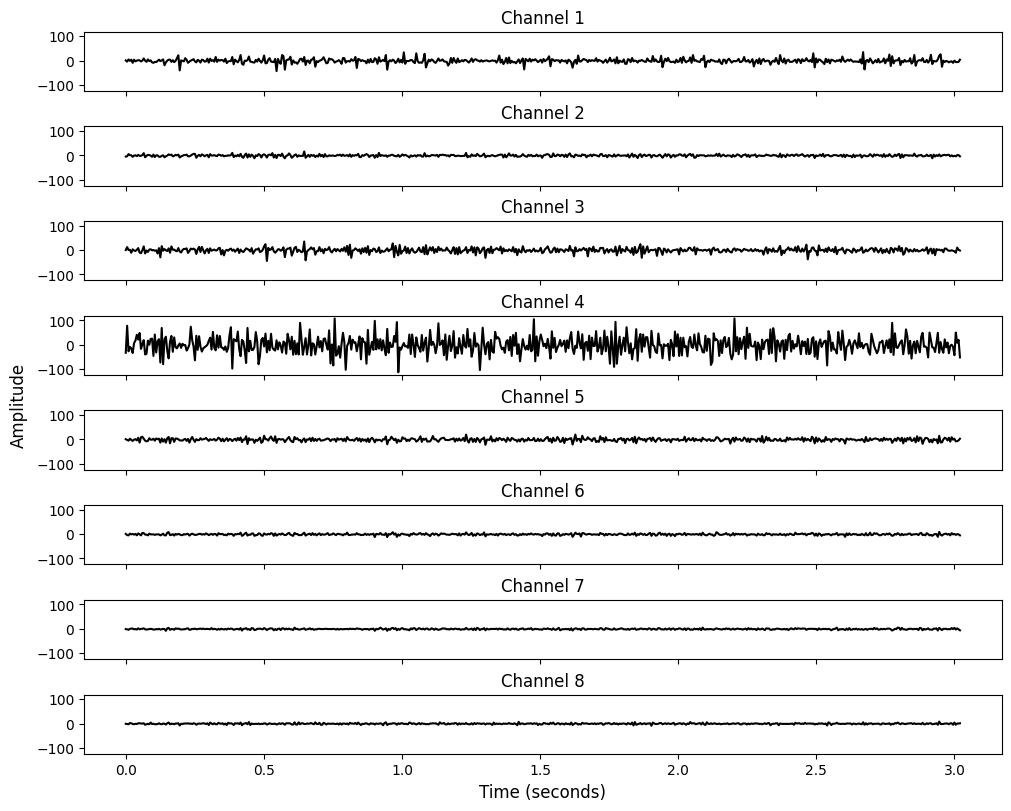

In [3]:
# Parse
odh = myo_dataset.prepare_data()    # look inside this method to explore the parsing interface
print(f"Number of files: {len(odh.data)}")
print(f"EMG data shape (samples x channels): {odh.data[0].shape}")
plot_channels(odh.data[0])

In [4]:
print(f"Single rep metadata: {odh.reps[0][:50].ravel()}")   # each type of metadata is stored as a (samples x M) array (M depends on the metadata)

Single rep metadata: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [5]:
print(f"Sets metadata: {[set[0, 0] for set in odh.sets]}")
print(f"Reps metadata: {[rep[0, 0] for rep in odh.reps]}")

Sets metadata: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Reps metadata: [1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0]


In [6]:
# Split based on metadata
train_odh = odh.isolate_data('sets', [0, 1])
test_odh = odh.isolate_data('sets', [3])
print(f"Number of training files: {len(train_odh.data)}")
print(f"Number of test files: {len(test_odh.data)}")

Number of training files: 20
Number of test files: 10


In [7]:
# You can also add OfflineDataHandler instances together
train_test_odh = train_odh + test_odh
print(f"Number of training files: {len(train_test_odh.data)}")

Number of training files: 30


EMG data shape (samples x channels): (604, 3)


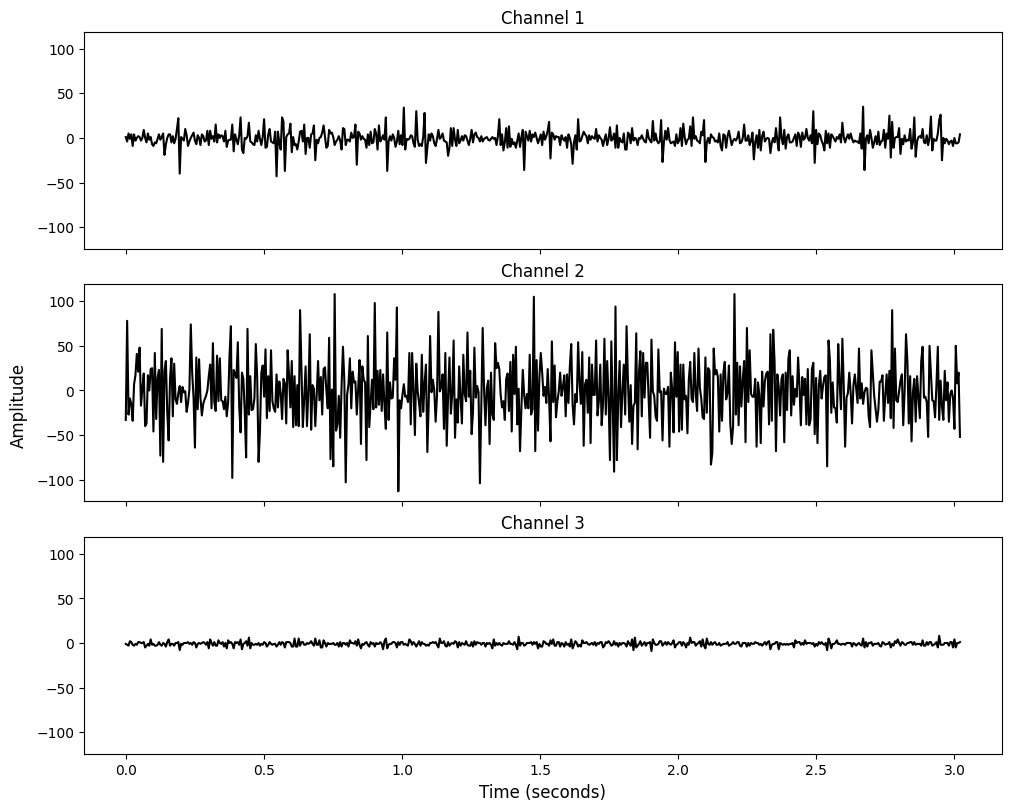

In [8]:
# Isolating by channels
channels_odh = odh.isolate_channels([0, 3, 7])
print(f"EMG data shape (samples x channels): {channels_odh.data[0].shape}")
plot_channels(channels_odh.data[0])

In [9]:
# Windowing
window_size, window_increment = get_window_parameters(MYO_FS)
windows, metadata = odh.parse_windows(window_size, window_increment)    # metadata grabbed based on mode by default, but can be customized with metadata_operations parameter
labels = metadata['classes']
print(f"Windows shape (windows x channels x samples): {windows.shape}")
print(f"Metadata shape (windows): {metadata['sets'].shape}")    # metadata value for each window
print(f"Example classes (windows): {metadata['classes'][:30]}")

Windows shape (windows x channels x samples): (3360, 8, 50)
Metadata shape (windows): (3360,)
Example classes (windows): [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


## Filtering

Filtering is a key component in a myoelectric control preprocessing pipeline due to the stochastic, noisy nature of EMG. `LibEMG` provides an interface to apply a variety of filters and offers convenience methods for commonly-used filters through the `Filter` class.

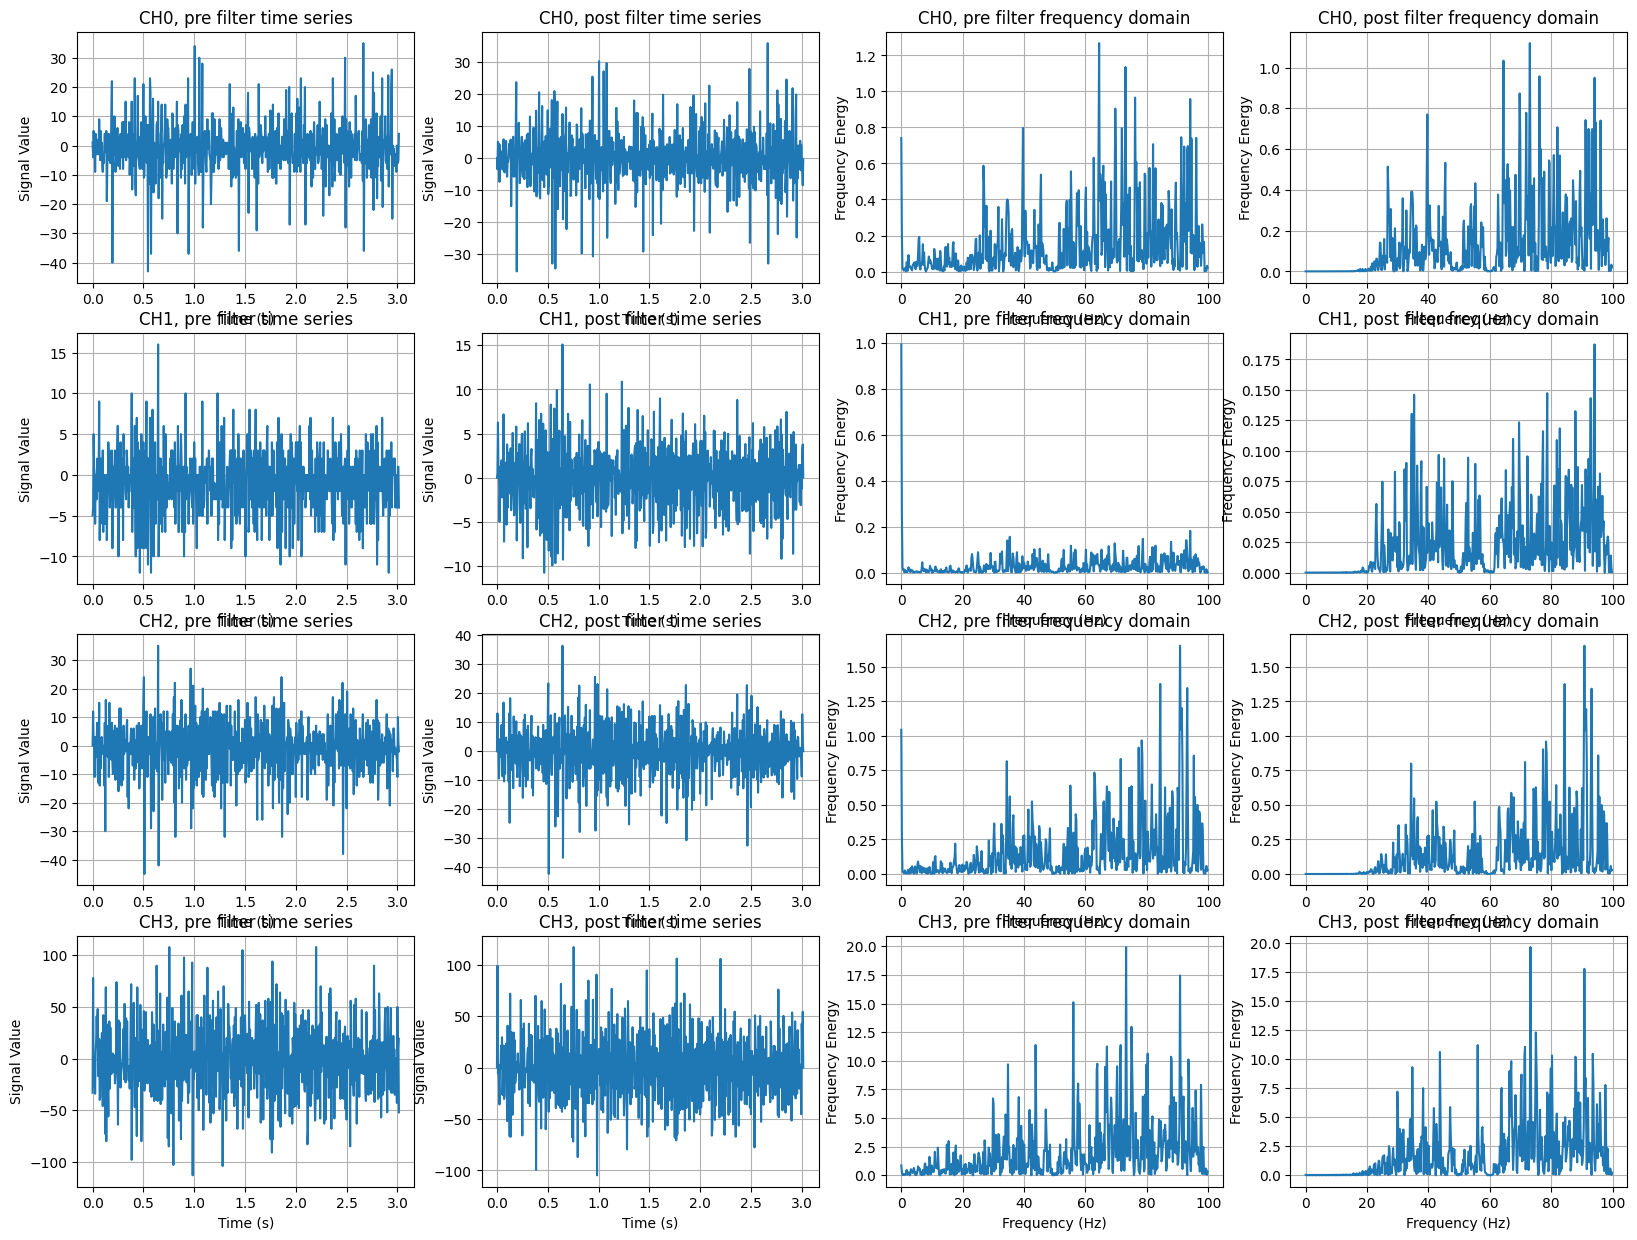

In [10]:
from libemg.filtering import Filter

filter = Filter(MYO_FS)
filter_configs = [
    {'name': 'notch', 'cutoff': 60, 'bandwidth': 3},
    {'name': 'highpass', 'cutoff': 20, 'order': 4}
]
for filter_config in filter_configs:
    filter.install_filters(filter_config)

filter.visualize_effect(odh.data[0][:, :4]) # lets us see the effect of filtering - we can see the removal of DC bias at 0 Hz

In [11]:
# Since the previous example is very common, LibEMG provides these filters in a convenience method
odh = myo_dataset.prepare_data()
filter = Filter(MYO_FS)
filter.install_common_filters()
filter.filter(odh)  # modify odh.data field internally

60 data files fetched out of 61 files.
sampling frequency is inadaquate for the set of common filters.


## Feature Extraction

After EMG data have been preprocessed, we often extract features that are later used for classification or regression. `LibEMG` contains 50 different feature extraction methods that can be leveraged by passing in the corresponding string. This section explores the `FeatureExtractor` and its use cases.

In [12]:
from libemg.feature_extractor import FeatureExtractor

fe = FeatureExtractor()
print(f"Number of feature extraction methods: {len(fe.get_feature_list())}")    # prints the accepted parameters for feature extraction
print(fe.get_feature_groups())  # we also offer passing in a 'feature group'

Number of feature extraction methods: 50
{'HTD': ['MAV', 'ZC', 'SSC', 'WL'], 'TSTD': ['MAVFD', 'DASDV', 'WAMP', 'ZC', 'MFL', 'SAMPEN', 'M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'], 'DFTR': ['DFTR'], 'ITD': ['ISD', 'COR', 'MDIFF', 'MLK'], 'HJORTH': ['ACT', 'MOB', 'COMP'], 'LS4': ['LS', 'MFL', 'MSR', 'WAMP'], 'LS9': ['LS', 'MFL', 'MSR', 'WAMP', 'ZC', 'RMS', 'IAV', 'DASDV', 'VAR'], 'TDPSD': ['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'], 'TDAR': ['MAV', 'ZC', 'SSC', 'WL', 'AR'], 'COMB': ['WL', 'SSC', 'LD', 'AR9'], 'MSWT': ['WENG', 'WV', 'WWL', 'WENT']}


In [13]:
# Features are returned as a dictionary by default
feature_dict = fe.extract_feature_group('HTD', windows) # extract Hudgins' Time Domain (HTD) feature set
print(feature_dict.keys())

# Set array=True to return a matrix
features = fe.extract_feature_group('HTD', windows, array=True)
print(f"Feature matrix (windows x features): {features.shape}")

dict_keys(['MAV', 'ZC', 'SSC', 'WL'])
Feature matrix (windows x features): (3360, 32)


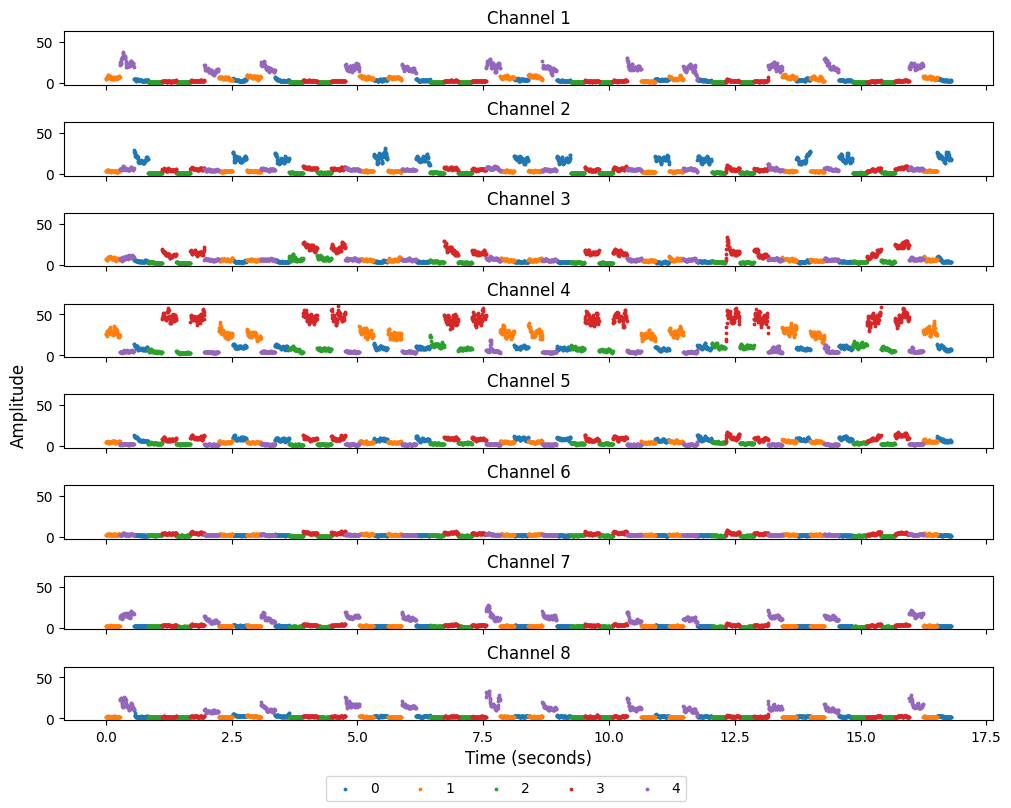

In [14]:
# Extract MAV and plot metadata
mav = fe.extract_features(['MAV'], windows, array=True)

plot_channels(mav, labels=labels)

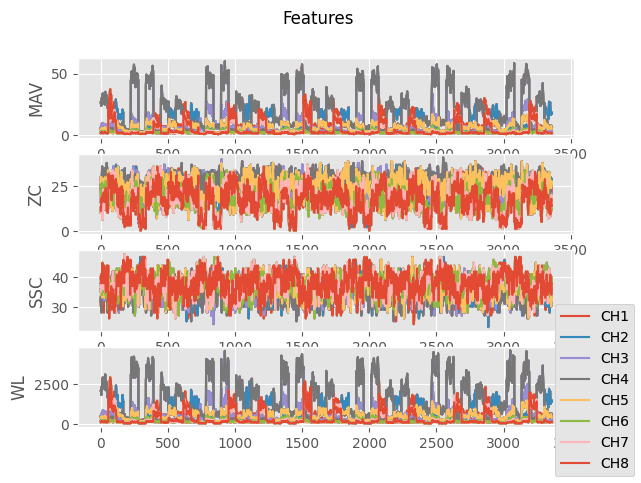

In [15]:
# Convenience methods to visualize features
fe.visualize(feature_dict)

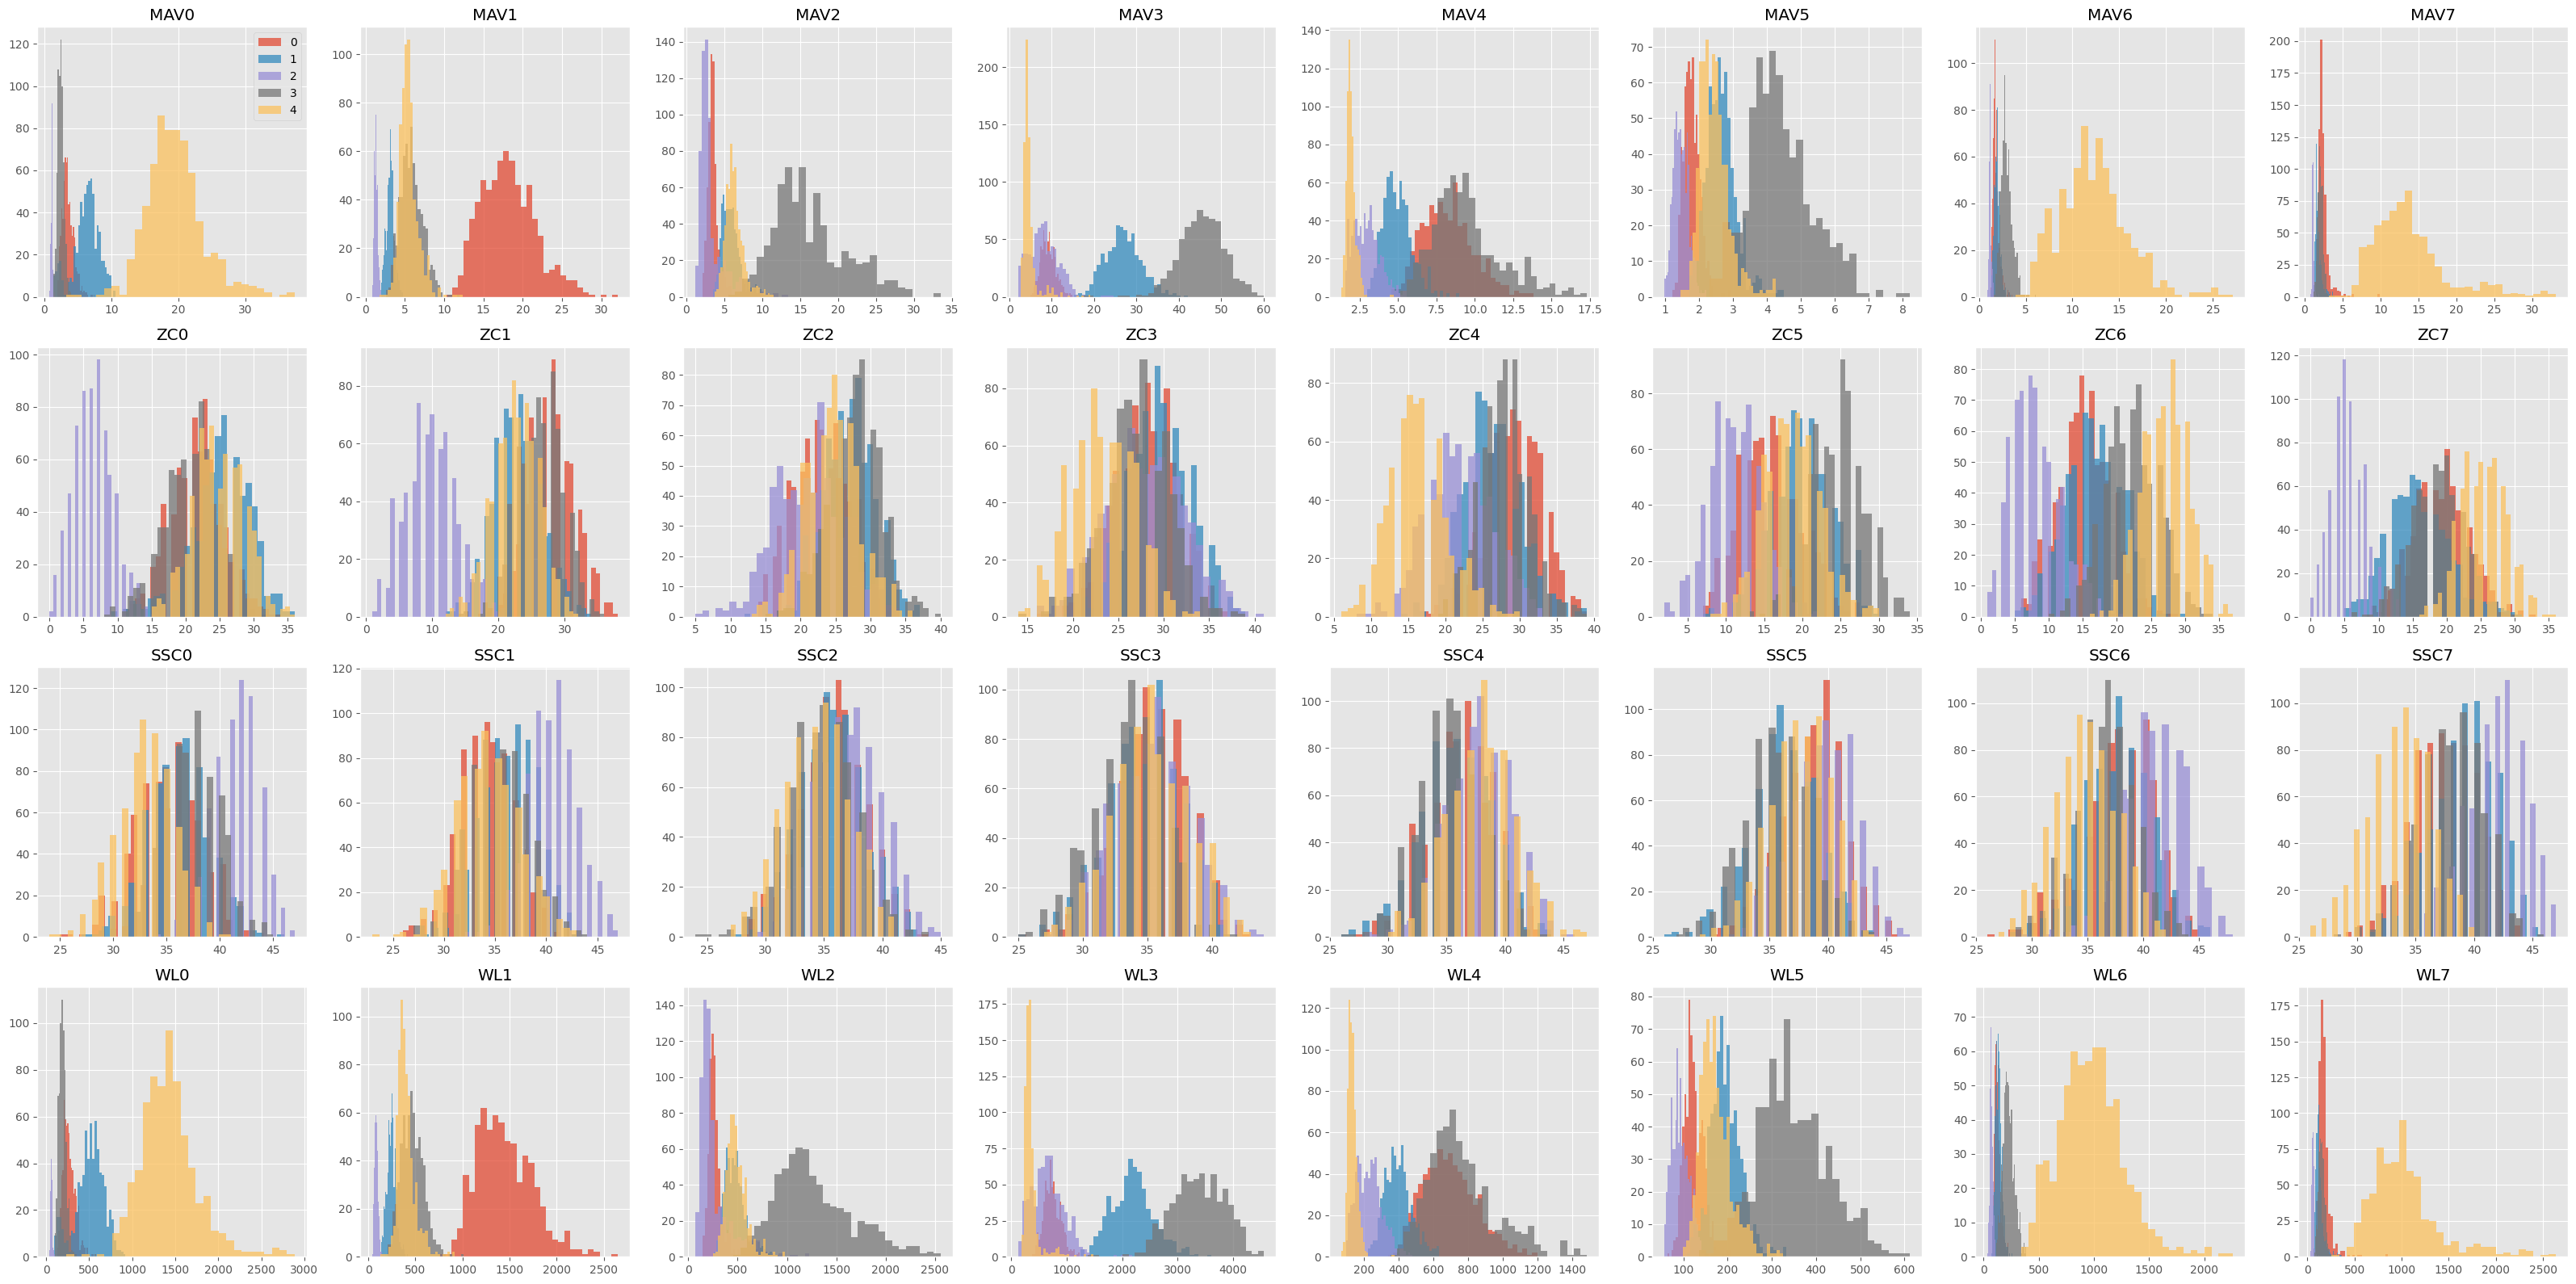

In [16]:
fe.visualize_all_distributions(feature_dict, classes=labels)

['pca', 'kernelpca', 'ica', 'lda', 'tsne', 'isomap']


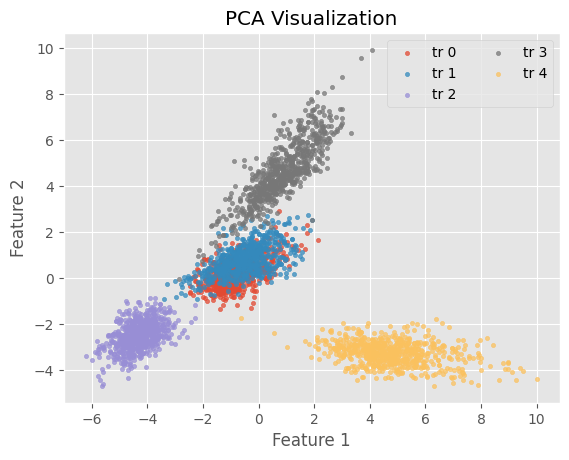

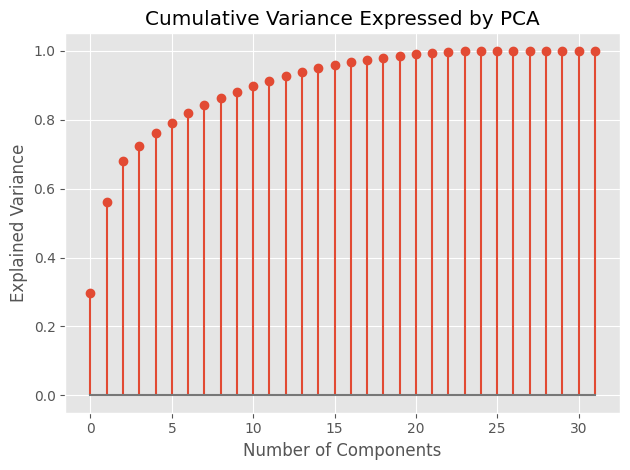

In [17]:
print(fe.get_projection_list())
fe.visualize_feature_space(feature_dict, 'pca', classes=labels)

In [18]:
def extract_features_labels(odh, method):
    # Now we can define a function that will convert from an OfflineDataHandler to a feature matrix ready for prediction
    if method == 'classification':
        fs = MYO_FS
        metadata_operations = None
        labels_key = 'classes'
    elif method == 'regression':
        fs = EMAGER_FS
        grab_last_sample = lambda x: x[-1]
        metadata_operations = {'labels': grab_last_sample}   # define a function
        labels_key = 'labels'
    else:
        raise ValueError(f"Received unexpected value for method parameter. Accepted parameters are 'classification' or 'regression'. Got: {method}.")
    
    odh = deepcopy(odh) # make a copy b/c filter modifies odh
    filter = Filter(fs)
    filter.install_common_filters()
    filter.filter(odh)

    window_size, window_increment = get_window_parameters(fs)
    windows, metadata = odh.parse_windows(window_size, window_increment, metadata_operations=metadata_operations)

    fe = FeatureExtractor()
    features = fe.extract_feature_group('HTD', windows, array=True)
    return features, metadata[labels_key]

## Model Training

Once data are prepared, we can pass them to a control model for predictions. `LibEMG` offers two broad types of models: classifiers (`EMGClassifier`) and regressors (`EMGRegressor`). Both offer convenience methods for fitting and formatting predictions.

### Classification

Classification takes in a a set of EMG signals and outputs a discrete motion class. The `EMGClassifier` also offers some convenience methods, such as adding rejection, majority vote, and proportional control (not shown here because this is an offline example).

60 data files fetched out of 61 files.
sampling frequency is inadaquate for the set of common filters.
sampling frequency is inadaquate for the set of common filters.
Predictions (windows): (1680,)
Probabilities (windows): (1680,)


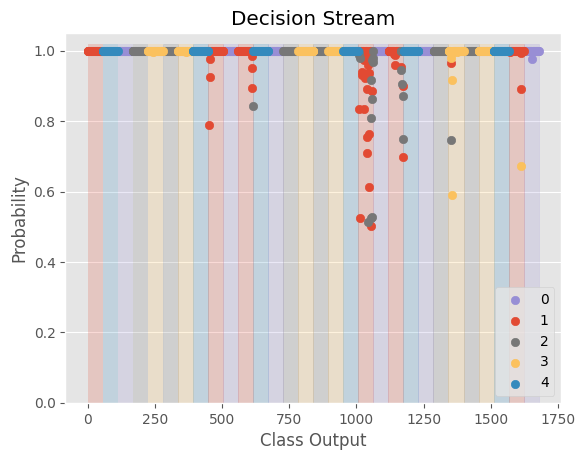

In [19]:
from libemg.emg_predictor import EMGClassifier

# Use OneSubjectMyoDataset for training and testing
myo_odh = myo_dataset.prepare_data()
train_myo_odh = myo_odh.isolate_data('sets', [0])
test_myo_odh = myo_odh.isolate_data('sets', [3, 4, 5])
train_myo_features, train_myo_labels = extract_features_labels(train_myo_odh, 'classification')
test_myo_features, test_myo_labels = extract_features_labels(test_myo_odh, 'classification')

# Create model
clf = EMGClassifier('LDA')  # can pass in custom deep learning models - anything with fit() and predict_proba() methods
feature_set = {
    'training_features': train_myo_features,
    'training_labels': train_myo_labels
}
clf.fit(feature_set)

# Make predictions
predictions, probabilities = clf.run(test_myo_features)
print(f"Predictions (windows): {predictions.shape}")
print(f"Probabilities (windows): {probabilities.shape}")
clf.visualize(test_myo_labels, predictions, probabilities)

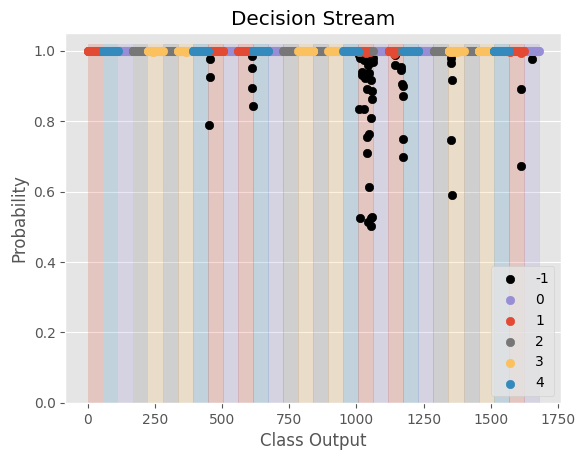

In [20]:
# Adding rejection
rejection_clf = deepcopy(clf)
rejection_clf.add_rejection(threshold=0.99)
predictions, probabilities = rejection_clf.run(test_myo_features) # prediction of -1 implies rejection
rejection_clf.visualize(test_myo_labels, predictions, probabilities)

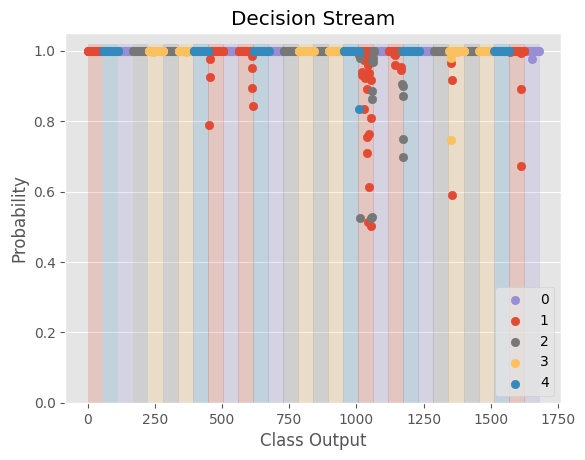

In [21]:
# Adding majority vote
mv_clf = deepcopy(clf)
mv_clf.add_majority_vote()
predictions, probabilities = mv_clf.run(test_myo_features)
mv_clf.visualize(test_myo_labels, predictions, probabilities)

### Regression

Regression takes in a a set of EMG signals and outputs a continuous motion estimate describing the user's point along a degree of freedom. The `EMGRegressor` also offers some convenience methods, such as adding a deadband to the output of the model.

10 data files fetched out of 12 files.
Predictions (windows x DOFs): (880, 2)


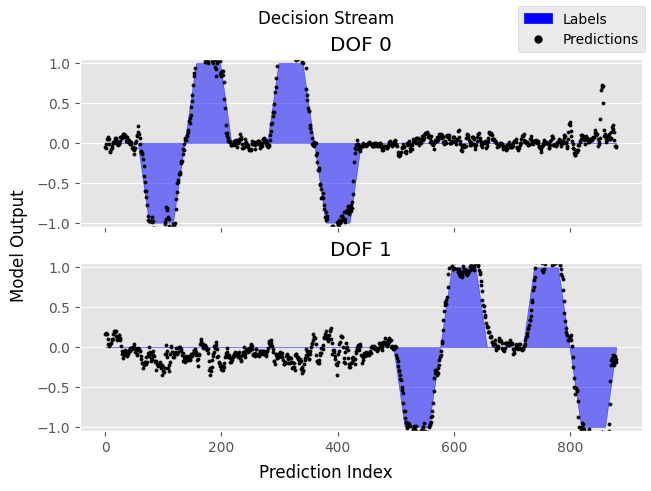

In [22]:
from libemg.emg_predictor import EMGRegressor

# Use OneSubjectEMaGerDataset for training and testing
emager_odh = emager_dataset.prepare_data()
train_emager_odh = emager_odh.isolate_data('reps', [0, 1, 2, 3])
test_emager_odh = emager_odh.isolate_data('reps', [4])
train_emager_features, train_emager_labels = extract_features_labels(train_emager_odh, 'regression')
test_emager_features, test_emager_labels = extract_features_labels(test_emager_odh, 'regression')

# Create model
reg = EMGRegressor('LR')    # can pass in custom deep learning models - anything with fit() and predict() methods
feature_set = {
    'training_features': train_emager_features,
    'training_labels': train_emager_labels
}
reg.fit(feature_set)

# Make predictions
predictions = reg.run(test_emager_features)
print(f"Predictions (windows x DOFs): {predictions.shape}")
reg.visualize(test_emager_labels, predictions)

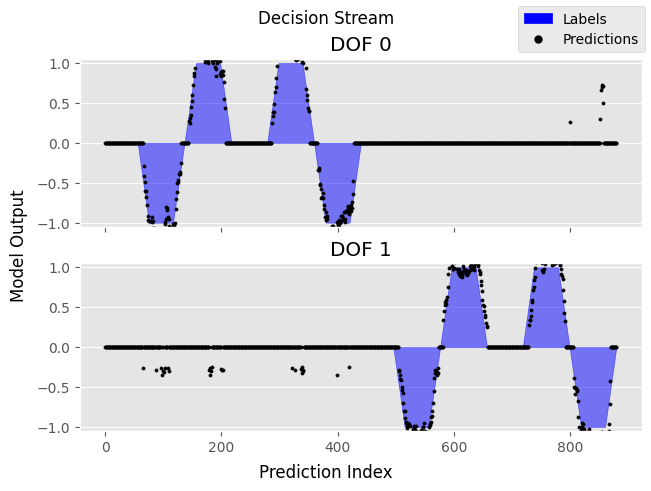

In [23]:
# Adding deadband
deadband_reg = deepcopy(reg)
deadband_reg.add_deadband(0.25)
predictions = deadband_reg.run(test_emager_features)
deadband_reg.visualize(test_emager_labels, predictions)

## Offline Metrics

Offline metrics allow us to assess a model's performance before testing it online. The `OnlineMetrics` class provides a simple interface for extracting common offline metrics.

In [24]:
from libemg.offline_metrics import OfflineMetrics

om = OfflineMetrics()
print(om.get_available_metrics())

['CA', 'AER', 'INS', 'REJ_RATE', 'CONF_MAT', 'RECALL', 'PREC', 'F1', 'R2', 'MSE', 'MAPE', 'RMSE', 'NRMSE', 'MAE']


{'CA': 0.9845238095238096, 'AER': 0.002271006813020393, 'INS': 0.011904761904761904}


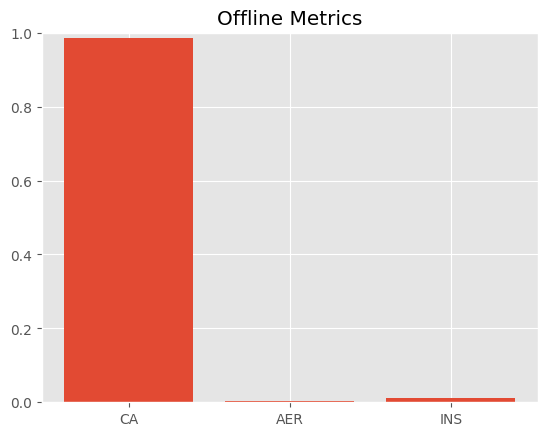

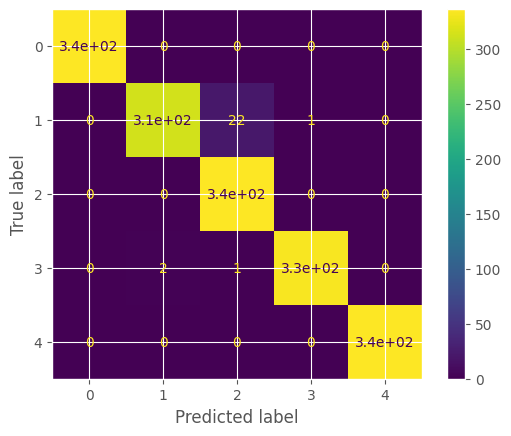

In [25]:
# Classification example
clf_predictions, _ = clf.run(test_myo_features)
null_label = 2  # value corresponding to no motion - defined based on the dataset
classification_metrics = om.extract_common_metrics(test_myo_labels, clf_predictions, null_label=null_label)    # extracts some common classification metrics
print(classification_metrics)
om.visualize(classification_metrics)

# Visualize confusion matrix
mat = om.get_CONF_MAT(test_myo_labels, clf_predictions)
om.visualize_conf_matrix(mat)

{'MAE': array([0.09315346, 0.10992963]), 'NRMSE': array([0.07419044, 0.06775971]), 'R2': array([0.9104981, 0.9251897])}


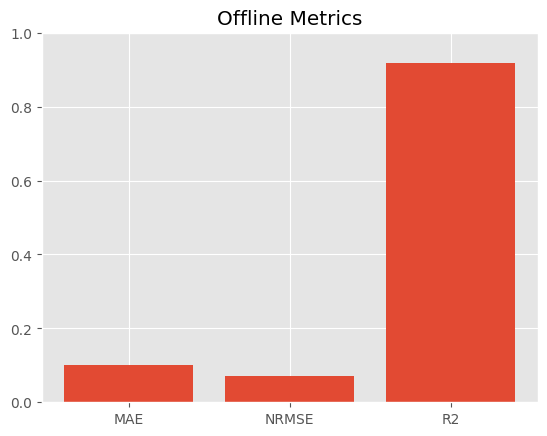

In [26]:
# Regression example
reg_predictions = reg.run(test_emager_features)
regression_metrics = om.extract_offline_metrics(['MAE', 'NRMSE', 'R2'], test_emager_labels, reg_predictions)
print(regression_metrics)

regression_metrics = {metric: value.mean() for metric, value in regression_metrics.items()}
om.visualize(regression_metrics)

## Summary

We hope that you have enjoyed this interactive walkthrough of `LibEMG`! 

* [GitHub](https://github.com/LibEMG/libemg)
  * Feature requests
  * Bug reports
  * Source code
* [Documentation](https://libemg.github.io/libemg/index.html#)
  * Explore API
  * See detailed explanation and types
* [Discord channel](https://discord.gg/vyDxc848eD)
  * Communicate with core maintainers
  * Collaborate with other users of `LibEMG`
